In [99]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [100]:
from sklearn.metrics import mean_squared_error

# LSTM FORECASTING SETUP

Defining methods to set up data to return sequences of varying lengths (n_steps) for x and y:


We also plan to try to clean up the data more exhaustively.

In [101]:
LSTMData = pd.read_csv("/home/jik19004/FilesToRun/DINGRESEARCH/DingResearchDec28th/DingLSTMFolder/FINALIZED_DATA.csv")
display(LSTMData)

,Demand,Annual Usage (kWh),Year,Month,Day,Hour,WeekDay or Weekend,HVN_lon,HVN_lat,HVN_tmpf,...,DXR_drct,DXR_sknt,DXR_vsby,MMK_lon,MMK_lat,MMK_tmpf,MMK_drct,MMK_sknt,MMK_vsby,HotTemperatures
0,3053.00,13244.454545,2011,1,1,0,0,-72.8868,41.2638,33.980000,...,0.000000,0.000000,5.000000,-72.83,41.51,28.94,0.0,0.0,4.0,0
1,2892.00,13244.454545,2011,1,1,1,0,-72.8868,41.2638,37.940000,...,0.000000,0.000000,5.000000,-72.83,41.51,28.94,0.0,0.0,4.0,0
2,2774.00,13244.454545,2011,1,1,2,0,-72.8868,41.2638,37.040000,...,0.000000,0.000000,4.000000,-72.83,41.51,33.08,150.0,5.0,5.0,0
3,2710.00,13244.454545,2011,1,1,3,0,-72.8868,41.2638,33.980000,...,0.000000,0.000000,4.000000,-72.83,41.51,33.08,150.0,4.0,6.0,0
4,2698.00,13244.454545,2011,1,1,4,0,-72.8868,41.2638,30.920000,...,0.000000,0.000000,4.000000,-72.83,41.51,28.94,100.0,3.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96422,3310.60,14064.500000,2021,12,31,19,1,-72.8868,41.2638,46.133333,...,46.666667,1.333333,6.666667,-72.83,41.51,43.00,0.0,0.0,4.0,0
96423,3148.00,14064.500000,2021,12,31,20,1,-72.8868,41.2638,46.133333,...,46.666667,1.333333,6.666667,-72.83,41.51,43.00,0.0,0.0,4.0,0
96424,2988.93,14064.500000,2021,12,31,21,1,-72.8868,41.2638,46.133333,...,46.666667,1.333333,6.666667,-72.83,41.51,43.00,0.0,0.0,4.0,0
96425,2793.70,14064.500000,2021,12,31,22,1,-72.8868,41.2638,46.133333,...,46.666667,1.333333,6.666667,-72.83,41.51,43.00,0.0,0.0,4.0,0


# Splitting the Data into Training, Validation, and Testing! 

In [102]:
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameter 
import tensorflow as tf 
from tensorflow import keras as keras 

from tensorflow.python.client import device_lib
def get_available_devices():
     local_device_protos = device_lib.list_local_devices()
     return [x.name for x in local_device_protos]
print(get_available_devices())

['/device:CPU:0']


2024-01-03 11:10:45.188271: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


FOR LSTM Use previous data strictly to predict time t. 
Example: t-5,t-4,t-3,t-2,t-1 to predict the t time. 
This makes sense logically because at time t, you will obtain the values on that day but we want to predict ahead of time! 

In [103]:
DemandData = LSTMData.loc[:,"Demand"].copy()
def return_sequences(data, outputData, input_n_steps, output_n_steps):
    X = []
    Y = []
    length = len(data)
    for i in range(0,length, 1):
        input_indx = i + input_n_steps
        output_indx = input_indx + output_n_steps 
        if (output_indx > len(data)): # we need to have equally split sequences. 
            break               # The remaining data that cannot fit into a fixed
                                # sequence will immediately be cut!
        else:
            Xsample = data.iloc[i:input_indx, :] # get the previous data
            Ysample = outputData[input_indx:output_indx]
            X.append(Xsample)
            Y.append(Ysample) 
    X = np.asarray(X).astype('float64')
    Y = np.asarray(Y).astype('float64')
    return (X, Y)


In [104]:
from sklearn.preprocessing import StandardScaler 
def scaleTheData(data):
    scaler = StandardScaler()
    # split the data first. 
    data2 = scaler.fit_transform(data)
    data = pd.DataFrame(data2, columns = data.columns)
    return data

def splitDataAndScale(data, output):    
    TrainingData = scaleTheData(data.iloc[:61363, :].copy()) # The index for Janruary 1st basically, don't necessarily hard code it. 
    # Janruary 1st 2018. 
    TrainingOutput = output[:61363].copy()

    RemainingData = data.iloc[61363:, :].copy()
    RemainingOutput = output[61363:].copy()

    ValidationData = scaleTheData(RemainingData.iloc[:int(0.5*len(RemainingData)), :].copy())
    ValidationOutput = RemainingOutput[:int(0.5*len(RemainingOutput))].copy()

    TestingData = scaleTheData(RemainingData.iloc[int(0.5 * len(RemainingData)):, :].copy())
    TestingOutput = RemainingOutput[int(0.5 * len(RemainingData)):].copy()


    TrainingSequences = return_sequences(TrainingData, TrainingOutput, 18, 1) 

    TransformedTrainingData = TrainingSequences[0]
    TransformedTrainingOutput = TrainingSequences[1]

    ValidationSequences = return_sequences(ValidationData, ValidationOutput, 18, 1)

    TransformedValidationData = ValidationSequences[0]
    TransformedValidationOutput = ValidationSequences[1]

    TestingSequences = return_sequences(TestingData, TestingOutput, 18, 1)

    TransformedTestingData = TestingSequences[0]
    TransformedTestingOutput = TestingSequences[1]



    return (TransformedTrainingData, TransformedTrainingOutput, TransformedValidationData, TransformedValidationOutput, 
    TransformedTestingData, TransformedTestingOutput)
    
    

In [105]:
data = splitDataAndScale(LSTMData, DemandData)

# LSTM Model Construction 

In [106]:
import torch 
class LSTMModel(torch.nn.Module):
    def __init__(self, alpha, num_layers, lastNeurons, params, output_num =1):
        super(LSTMModel, self).__init__()
        self.batchNorm0 = torch.nn.BatchNorm1d(num_features = 18)
        self.LSTM1 = torch.nn.LSTM(input_size = 56, hidden_size = 72, num_layers = 1, bias = True, batch_first = True)
        self.LSTM2 = torch.nn.LSTM(input_size = 72, hidden_size = 72, num_layers = 1, bias = True, batch_first = True)
        
        input_size = 72
        layers = [] 
        for i in range(num_layers):
            num_units = params[i]
            layers.append(torch.nn.Linear(input_size, num_units, bias = True))
            layers.append(torch.nn.LeakyReLU(negative_slope = 0.25))
            layers.append(torch.nn.BatchNorm1d(num_features = 18))
            layers.append(torch.nn.Dropout(0.35))
            input_size = num_units
        self.intermediateLayers = torch.nn.Sequential(*layers)
        self.Linear1 = torch.nn.Linear(in_features = input_size, out_features = lastNeurons, bias = True)
        self.Activation1 = torch.nn.LeakyReLU(negative_slope = 0.25)
        self.Dropout = torch.nn.Dropout(0.35)
        
        
        self.Linear2 = torch.nn.Linear(in_features = lastNeurons * 18, out_features = output_num, bias =True)
        
    def forward(self, val):
        
        x = self.LSTM1(val)
        x = self.LSTM2(x[0], (x[1][0],x[1][1])) #(x[1][0], x[1][1])
        
        x = self.intermediateLayers(x[0])
        x = self.Linear1(x)
        x = self.Activation1(x)
        x = self.Dropout(x)
        x = x.view(-1, x.size(1) * x.size(2)) # flatten the tensor to 1 dimensional
        x = self.Linear2(x)
        
        return x
        
        

In [107]:
import optuna 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class TimeSeriesDataset(Dataset):
    def __init__(self, data, output):
        data = torch.tensor(data).float(); 
        output = torch.tensor(output).float() 
        self.data = data 
        self.output = output; 

    def __len__(self):
        return len(self.data) 

    def __getitem__(self, idx):
        x = self.data[idx];  
        y = self.output[idx]; 
        
        return x, y; 

# use the past 72 hours in advance and then predict the 1st hour, 6th hour, 12 hours! 

def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item() * target.size(0)
    return running_loss / len(val_loader.dataset)

def Train_and_Evaluate(train_loader, val_loader, device, params1, params2, numEpochs, early_stop_epochs):
    #num_layers, dropout = 0.1, outfeatures1 = 16, outfeatures2 = 16, outfeatures3 = 16, outfeatures4 = 16, dim_feedforward = 2048, output_num = 1
    model = LSTMModel(alpha = params1[0], num_layers = params1[1], lastNeurons= params1[2], params = params2)
    model = model.to(device);
    LossFunction = torch.nn.L1Loss();
    best_val_loss = float('inf')
    early_stop_count = 0
   
    
    Optimizer = torch.optim.Adam(params = model.parameters(), weight_decay = 0.001)
    for epoch in range(0,numEpochs):
        model.train() 
        Training_Loss = 0; 
        total_samples = 0; 
        for input, output in train_loader:
            input = input.to(device); 
            output = torch.squeeze(output, 1); 
            output = output.to(device); 
            predictedVal = model(input)
            predictedVal = torch.squeeze(predictedVal, 1)
            Optimizer.zero_grad();
            batchLoss = LossFunction(predictedVal, output);
            batchLoss.backward(); 
            Optimizer.step();
            Training_Loss += batchLoss * output.size(0) #* output.size(0);
            total_samples += output.size(0)
        Training_Loss = Training_Loss.item()/total_samples


        Validation_Loss = 0; 
        print("passed ", epoch, "epoch", "Training Loss: ", Training_Loss," ", end = "")
        with torch.no_grad():
            model.eval()
            total_val_samples = 0; 
            Validation_Loss = 0; 
            for val_input, val_output in val_loader:
                val_input = val_input.to(device); 
                val_output = torch.squeeze(val_output,1);
                val_output = val_output.to(device);
                predictedVal = model(val_input)
                predictedVal = torch.squeeze(predictedVal, 1)
                Validation_Loss += LossFunction(val_output, predictedVal) * val_output.size(0)
                total_val_samples += val_output.size(0)
            Validation_Loss = Validation_Loss/total_val_samples
            print("Validation Loss: ", Validation_Loss)

            if Validation_Loss < best_val_loss:
                best_val_loss = Validation_Loss
                early_stop_count = 0;
            else:
                early_stop_count +=1 
            if early_stop_count >= early_stop_epochs:
                return best_val_loss; 

    return best_val_loss; 

def predict(model, data_loader, device):
    model.eval()
    predictions = []
    act_outputs = []
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            output = model(data)
            predictions.append(output.cpu().numpy())
            act_outputs.append(_.numpy())

    return (np.concatenate(predictions), np.concatenate(act_outputs))
    

In [108]:
x = torch.randn(1,1).squeeze(0)
y = torch.randn(1) 



print(x.shape)
print(y.shape)
print(x)
print(y)
loss = torch.nn.L1Loss()
print(loss(x,y))

torch.Size([1])
torch.Size([1])
tensor([-1.0148])
tensor([0.8003])
tensor(1.8151)


In [109]:
TrainingData = TimeSeriesDataset(data[0],data[1]);
TrainingLoader = DataLoader(TrainingData, batch_size = 128);


ValidationData = TimeSeriesDataset(data[2],data[3]);
ValidationLoader = DataLoader(ValidationData, batch_size = 128);


TestingData = TimeSeriesDataset(data[4],data[5]);
TestingLoader = DataLoader(TestingData, batch_size = 256);

In [110]:
def objective(trial):
    #num_layers = params[0], outfeatures = params[1], dim_feedforward = params[2]
    params1 = [trial.suggest_float("alpha", low = 0.2, high = 0.25, log=True), 
              trial.suggest_int("num_layers", low = 2, high = 4, step = 1),
              trial.suggest_int("last_hidden_neurons", low = 42, high = 90, step = 16)]
    
    params2 = [trial.suggest_int("num_hiddenZero", low = 74, high = 138, step = 16),
               trial.suggest_int("num_hiddenOne", low = 106, high = 180, step = 16),
               trial.suggest_int("num_hiddenTwo", low = 74, high = 138, step = 16),
               trial.suggest_int("num_hiddenThree", low = 58, high = 124, step = 16)]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
    return Train_and_Evaluate(TrainingLoader, ValidationLoader, device, params1, params2, 260, 10); 

import joblib 
study_name = 'sqlite:///LSTMOutput1.db'
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), study_name = "NewLSTM1", load_if_exists= True, storage='sqlite:///LSTMOutput1.db')
joblib.dump(study, "LSTMOutput1.pkl")
study.optimize(objective, n_trials = 160)

[I 2024-01-03 11:10:52,995] A new study created in RDB with name: NewLSTM1


/home/jik19004/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:716: UserWarning: The distribution is specified by [106, 180] and step=16, but the range is not divisible by `step`. It will be replaced by [106, 170].
  warnings.warn(
/home/jik19004/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:716: UserWarning: The distribution is specified by [58, 124] and step=16, but the range is not divisible by `step`. It will be replaced by [58, 122].
  warnings.warn(


passed  0 epoch Training Loss:  880.6781970820767  Validation Loss:  tensor(330.1264, device='cuda:2')
passed  1 epoch Training Loss:  277.41602412584564  Validation Loss:  tensor(262.7103, device='cuda:2')
passed  2 epoch Training Loss:  195.92732904067162  Validation Loss:  tensor(235.2226, device='cuda:2')
passed  3 epoch Training Loss:  153.43904148667374  Validation Loss:  tensor(210.5853, device='cuda:2')
passed  4 epoch Training Loss:  135.80438503545523  Validation Loss:  tensor(282.7697, device='cuda:2')
passed  5 epoch Training Loss:  127.24490993561007  Validation Loss:  tensor(230.3855, device='cuda:2')
passed  6 epoch Training Loss:  121.06069769337354  Validation Loss:  tensor(202.4995, device='cuda:2')
passed  7 epoch Training Loss:  116.13954682533213  Validation Loss:  tensor(99.3901, device='cuda:2')
passed  8 epoch Training Loss:  112.88489689461244  Validation Loss:  tensor(82.5683, device='cuda:2')
passed  9 epoch Training Loss:  110.09532969272149  Validation Loss

[I 2024-01-03 11:13:26,857] Trial 0 finished with value: 56.42011260986328 and parameters: {'alpha': 0.20911398805529885, 'num_layers': 2, 'last_hidden_neurons': 74, 'num_hiddenZero': 106, 'num_hiddenOne': 154, 'num_hiddenTwo': 90, 'num_hiddenThree': 122}. Best is trial 0 with value: 56.42011260986328.


Validation Loss:  tensor(67.1106, device='cuda:2')
passed  0 epoch Training Loss:  987.5037248349498  Validation Loss:  tensor(362.2501, device='cuda:2')
passed  1 epoch Training Loss:  284.74434754258704  Validation Loss:  tensor(186.8015, device='cuda:2')
passed  2 epoch Training Loss:  212.00819952726383  Validation Loss:  tensor(140.5477, device='cuda:2')
passed  3 epoch Training Loss:  174.40132040101068  Validation Loss:  tensor(133.2731, device='cuda:2')
passed  4 epoch Training Loss:  154.85141413318118  Validation Loss:  tensor(192.7974, device='cuda:2')
passed  5 epoch Training Loss:  144.61832260167904  Validation Loss:  tensor(124.7401, device='cuda:2')
passed  6 epoch Training Loss:  138.31601597522211  Validation Loss:  tensor(95.5427, device='cuda:2')
passed  7 epoch Training Loss:  127.68681229114027  Validation Loss:  tensor(91.3181, device='cuda:2')
passed  8 epoch Training Loss:  120.96720189094465  Validation Loss:  tensor(74.9615, device='cuda:2')
passed  9 epoch T

[I 2024-01-03 11:15:37,729] Trial 1 finished with value: 58.57508850097656 and parameters: {'alpha': 0.20467440131849338, 'num_layers': 4, 'last_hidden_neurons': 58, 'num_hiddenZero': 74, 'num_hiddenOne': 138, 'num_hiddenTwo': 74, 'num_hiddenThree': 106}. Best is trial 0 with value: 56.42011260986328.


Validation Loss:  tensor(105.3643, device='cuda:2')
passed  0 epoch Training Loss:  945.3717173363763  Validation Loss:  tensor(323.6409, device='cuda:2')
passed  1 epoch Training Loss:  278.673241502975  Validation Loss:  tensor(190.7724, device='cuda:2')
passed  2 epoch Training Loss:  200.97483087456192  Validation Loss:  tensor(138.3645, device='cuda:2')
passed  3 epoch Training Loss:  167.19333278995842  Validation Loss:  tensor(163.2808, device='cuda:2')
passed  4 epoch Training Loss:  142.26919879370772  Validation Loss:  tensor(143.4653, device='cuda:2')
passed  5 epoch Training Loss:  131.37911810253485  Validation Loss:  tensor(135.2010, device='cuda:2')
passed  6 epoch Training Loss:  127.41669247697449  Validation Loss:  tensor(93.6429, device='cuda:2')
passed  7 epoch Training Loss:  120.90132040101068  Validation Loss:  tensor(94.1907, device='cuda:2')
passed  8 epoch Training Loss:  118.15622300105959  Validation Loss:  tensor(59.6044, device='cuda:2')
passed  9 epoch Tr

[I 2024-01-03 11:17:17,040] Trial 2 finished with value: 59.6043701171875 and parameters: {'alpha': 0.224118480482362, 'num_layers': 3, 'last_hidden_neurons': 90, 'num_hiddenZero': 122, 'num_hiddenOne': 122, 'num_hiddenTwo': 90, 'num_hiddenThree': 58}. Best is trial 0 with value: 56.42011260986328.


Validation Loss:  tensor(103.0457, device='cuda:2')
passed  0 epoch Training Loss:  1087.9222104490993  Validation Loss:  tensor(349.8802, device='cuda:2')
passed  1 epoch Training Loss:  311.54108729317795  Validation Loss:  tensor(264.3164, device='cuda:2')
passed  2 epoch Training Loss:  225.18395957290733  Validation Loss:  tensor(291.2305, device='cuda:2')
passed  3 epoch Training Loss:  192.63441193251285  Validation Loss:  tensor(289.0910, device='cuda:2')
passed  4 epoch Training Loss:  166.66112967642025  Validation Loss:  tensor(276.9665, device='cuda:2')
passed  5 epoch Training Loss:  150.74367919145814  Validation Loss:  tensor(252.3726, device='cuda:2')
passed  6 epoch Training Loss:  144.77662401173689  Validation Loss:  tensor(222.6541, device='cuda:2')
passed  7 epoch Training Loss:  136.3604613252914  Validation Loss:  tensor(239.1622, device='cuda:2')
passed  8 epoch Training Loss:  132.4891596707148  Validation Loss:  tensor(181.2027, device='cuda:2')
passed  9 epoc

[I 2024-01-03 11:19:58,210] Trial 3 finished with value: 81.06844329833984 and parameters: {'alpha': 0.23066752952469813, 'num_layers': 4, 'last_hidden_neurons': 58, 'num_hiddenZero': 74, 'num_hiddenOne': 170, 'num_hiddenTwo': 74, 'num_hiddenThree': 90}. Best is trial 0 with value: 56.42011260986328.


Validation Loss:  tensor(151.0950, device='cuda:2')
passed  0 epoch Training Loss:  1004.752269948651  Validation Loss:  tensor(308.2935, device='cuda:2')
passed  1 epoch Training Loss:  272.8236531094629  Validation Loss:  tensor(214.7940, device='cuda:2')
passed  2 epoch Training Loss:  197.53909854103838  Validation Loss:  tensor(193.4101, device='cuda:2')
passed  3 epoch Training Loss:  168.10274676012716  Validation Loss:  tensor(146.7099, device='cuda:2')
passed  4 epoch Training Loss:  151.2088678783927  Validation Loss:  tensor(150.0509, device='cuda:2')
passed  5 epoch Training Loss:  138.2400032602494  Validation Loss:  tensor(180.7968, device='cuda:2')
passed  6 epoch Training Loss:  133.6959002363681  Validation Loss:  tensor(159.8770, device='cuda:2')
passed  7 epoch Training Loss:  124.10783274920531  Validation Loss:  tensor(107.9454, device='cuda:2')
passed  8 epoch Training Loss:  119.23911484228543  Validation Loss:  tensor(79.7166, device='cuda:2')
passed  9 epoch Tr

[I 2024-01-03 11:22:11,203] Trial 4 finished with value: 71.90450286865234 and parameters: {'alpha': 0.22870509101860725, 'num_layers': 4, 'last_hidden_neurons': 74, 'num_hiddenZero': 106, 'num_hiddenOne': 122, 'num_hiddenTwo': 106, 'num_hiddenThree': 74}. Best is trial 0 with value: 56.42011260986328.


Validation Loss:  tensor(92.7428, device='cuda:2')
passed  0 epoch Training Loss:  1051.8543320564024  Validation Loss:  tensor(359.8179, device='cuda:2')
passed  1 epoch Training Loss:  284.11541282908144  Validation Loss:  tensor(261.5674, device='cuda:2')
passed  2 epoch Training Loss:  197.67770804466542  Validation Loss:  tensor(196.8879, device='cuda:2')
passed  3 epoch Training Loss:  171.54201646425952  Validation Loss:  tensor(204.1628, device='cuda:2')
passed  4 epoch Training Loss:  149.9121036759312  Validation Loss:  tensor(158.1479, device='cuda:2')
passed  5 epoch Training Loss:  140.3617898769256  Validation Loss:  tensor(165.1954, device='cuda:2')
passed  6 epoch Training Loss:  135.0908794522781  Validation Loss:  tensor(152.0829, device='cuda:2')
passed  7 epoch Training Loss:  131.31549433531666  Validation Loss:  tensor(127.0338, device='cuda:2')
passed  8 epoch Training Loss:  127.9982394653191  Validation Loss:  tensor(127.4682, device='cuda:2')
passed  9 epoch T

[I 2024-01-03 11:24:53,008] Trial 5 finished with value: 71.77749633789062 and parameters: {'alpha': 0.21330404593980212, 'num_layers': 4, 'last_hidden_neurons': 58, 'num_hiddenZero': 90, 'num_hiddenOne': 154, 'num_hiddenTwo': 138, 'num_hiddenThree': 90}. Best is trial 0 with value: 56.42011260986328.


Validation Loss:  tensor(138.1262, device='cuda:2')
passed  0 epoch Training Loss:  901.8842285434836  Validation Loss:  tensor(270.0026, device='cuda:2')
passed  1 epoch Training Loss:  275.88432635096586  Validation Loss:  tensor(203.9327, device='cuda:2')
passed  2 epoch Training Loss:  206.78025918982803  Validation Loss:  tensor(143.3183, device='cuda:2')
passed  3 epoch Training Loss:  160.84539897302145  Validation Loss:  tensor(134.0333, device='cuda:2')
passed  4 epoch Training Loss:  136.4470372483495  Validation Loss:  tensor(171.1965, device='cuda:2')
passed  5 epoch Training Loss:  127.65484554568424  Validation Loss:  tensor(106.7575, device='cuda:2')
passed  6 epoch Training Loss:  123.2778466052653  Validation Loss:  tensor(98.5672, device='cuda:2')
passed  7 epoch Training Loss:  119.0806096666395  Validation Loss:  tensor(124.1260, device='cuda:2')
passed  8 epoch Training Loss:  115.05479664194311  Validation Loss:  tensor(205.3549, device='cuda:2')
passed  9 epoch T

[I 2024-01-03 11:27:28,483] Trial 6 finished with value: 54.77505874633789 and parameters: {'alpha': 0.2283696658596325, 'num_layers': 3, 'last_hidden_neurons': 90, 'num_hiddenZero': 138, 'num_hiddenOne': 138, 'num_hiddenTwo': 122, 'num_hiddenThree': 58}. Best is trial 6 with value: 54.77505874633789.


Validation Loss:  tensor(66.7563, device='cuda:2')
passed  0 epoch Training Loss:  902.4364495883935  Validation Loss:  tensor(287.5048, device='cuda:2')
passed  1 epoch Training Loss:  270.79802754910753  Validation Loss:  tensor(207.5916, device='cuda:2')
passed  2 epoch Training Loss:  206.30124704539898  Validation Loss:  tensor(122.8610, device='cuda:2')
passed  3 epoch Training Loss:  161.6495883935121  Validation Loss:  tensor(116.0702, device='cuda:2')
passed  4 epoch Training Loss:  146.0454967805037  Validation Loss:  tensor(103.2262, device='cuda:2')
passed  5 epoch Training Loss:  133.8319585948325  Validation Loss:  tensor(100.1630, device='cuda:2')
passed  6 epoch Training Loss:  127.57164398076453  Validation Loss:  tensor(130.3572, device='cuda:2')
passed  7 epoch Training Loss:  124.03362947265465  Validation Loss:  tensor(110.5097, device='cuda:2')
passed  8 epoch Training Loss:  117.74389925829325  Validation Loss:  tensor(71.9571, device='cuda:2')
passed  9 epoch Tr

[I 2024-01-03 11:31:46,444] Trial 7 finished with value: 55.439239501953125 and parameters: {'alpha': 0.2165513150288149, 'num_layers': 4, 'last_hidden_neurons': 90, 'num_hiddenZero': 122, 'num_hiddenOne': 170, 'num_hiddenTwo': 106, 'num_hiddenThree': 106}. Best is trial 6 with value: 54.77505874633789.


Validation Loss:  tensor(94.2181, device='cuda:2')
passed  0 epoch Training Loss:  1045.7008069117287  Validation Loss:  tensor(328.0844, device='cuda:2')
passed  1 epoch Training Loss:  269.4178009617736  Validation Loss:  tensor(245.4066, device='cuda:2')
passed  2 epoch Training Loss:  191.75702991278834  Validation Loss:  tensor(180.7337, device='cuda:2')
passed  3 epoch Training Loss:  174.6394653190969  Validation Loss:  tensor(211.5940, device='cuda:2')
passed  4 epoch Training Loss:  155.41413318118836  Validation Loss:  tensor(149.9877, device='cuda:2')
passed  5 epoch Training Loss:  167.30576249083055  Validation Loss:  tensor(115.1543, device='cuda:2')
passed  6 epoch Training Loss:  150.17246719374032  Validation Loss:  tensor(173.1245, device='cuda:2')
passed  7 epoch Training Loss:  144.3757600456435  Validation Loss:  tensor(153.1207, device='cuda:2')
passed  8 epoch Training Loss:  136.26424321460593  Validation Loss:  tensor(116.4110, device='cuda:2')
passed  9 epoch 

[I 2024-01-03 11:36:44,903] Trial 8 finished with value: 54.71077346801758 and parameters: {'alpha': 0.20327580740197831, 'num_layers': 2, 'last_hidden_neurons': 42, 'num_hiddenZero': 106, 'num_hiddenOne': 122, 'num_hiddenTwo': 90, 'num_hiddenThree': 74}. Best is trial 8 with value: 54.71077346801758.


Validation Loss:  tensor(65.0046, device='cuda:2')
passed  0 epoch Training Loss:  947.6641291058766  Validation Loss:  tensor(304.4986, device='cuda:2')
passed  1 epoch Training Loss:  281.03708533702826  Validation Loss:  tensor(201.8551, device='cuda:2')
passed  2 epoch Training Loss:  195.44676827777326  Validation Loss:  tensor(174.4452, device='cuda:2')
passed  3 epoch Training Loss:  156.24500774309234  Validation Loss:  tensor(186.3240, device='cuda:2')
passed  4 epoch Training Loss:  137.23534110359444  Validation Loss:  tensor(111.4359, device='cuda:2')
passed  5 epoch Training Loss:  128.10320319504441  Validation Loss:  tensor(107.4558, device='cuda:2')
passed  6 epoch Training Loss:  123.57476566957372  Validation Loss:  tensor(103.9567, device='cuda:2')
passed  7 epoch Training Loss:  119.60044828429375  Validation Loss:  tensor(86.3218, device='cuda:2')
passed  8 epoch Training Loss:  115.99845953215421  Validation Loss:  tensor(77.6977, device='cuda:2')
passed  9 epoch 

[I 2024-01-03 11:39:29,350] Trial 9 finished with value: 59.45975112915039 and parameters: {'alpha': 0.21434334881797903, 'num_layers': 3, 'last_hidden_neurons': 90, 'num_hiddenZero': 74, 'num_hiddenOne': 154, 'num_hiddenTwo': 90, 'num_hiddenThree': 74}. Best is trial 8 with value: 54.71077346801758.


Validation Loss:  tensor(225.8358, device='cuda:2')
passed  0 epoch Training Loss:  1063.7447224712691  Validation Loss:  tensor(309.2003, device='cuda:2')
passed  1 epoch Training Loss:  264.51523351536395  Validation Loss:  tensor(213.5633, device='cuda:2')
passed  2 epoch Training Loss:  192.78619284375256  Validation Loss:  tensor(206.1322, device='cuda:2')
passed  3 epoch Training Loss:  172.0370853370283  Validation Loss:  tensor(147.9496, device='cuda:2')
passed  4 epoch Training Loss:  160.21105224549677  Validation Loss:  tensor(193.6640, device='cuda:2')
passed  5 epoch Training Loss:  148.0106936180618  Validation Loss:  tensor(134.5999, device='cuda:2')
passed  6 epoch Training Loss:  142.28158774146223  Validation Loss:  tensor(114.4686, device='cuda:2')
passed  7 epoch Training Loss:  137.54508109870406  Validation Loss:  tensor(129.5850, device='cuda:2')
passed  8 epoch Training Loss:  133.1089330833809  Validation Loss:  tensor(111.3803, device='cuda:2')
passed  9 epoch

[I 2024-01-03 11:41:07,064] Trial 10 finished with value: 70.20826721191406 and parameters: {'alpha': 0.20030377965761317, 'num_layers': 2, 'last_hidden_neurons': 42, 'num_hiddenZero': 138, 'num_hiddenOne': 106, 'num_hiddenTwo': 122, 'num_hiddenThree': 74}. Best is trial 8 with value: 54.71077346801758.


Validation Loss:  tensor(98.4872, device='cuda:2')
passed  0 epoch Training Loss:  1045.0182410954437  Validation Loss:  tensor(320.8995, device='cuda:2')
passed  1 epoch Training Loss:  288.30313799005626  Validation Loss:  tensor(349.1029, device='cuda:2')
passed  2 epoch Training Loss:  215.88939603879697  Validation Loss:  tensor(287.8413, device='cuda:2')
passed  3 epoch Training Loss:  177.62197408101719  Validation Loss:  tensor(189.4576, device='cuda:2')
passed  4 epoch Training Loss:  155.1347624093243  Validation Loss:  tensor(239.8130, device='cuda:2')
passed  5 epoch Training Loss:  146.596055098215  Validation Loss:  tensor(179.3033, device='cuda:2')
passed  6 epoch Training Loss:  141.69484065531014  Validation Loss:  tensor(155.0462, device='cuda:2')
passed  7 epoch Training Loss:  138.14552123237428  Validation Loss:  tensor(93.1034, device='cuda:2')
passed  8 epoch Training Loss:  130.8136115412829  Validation Loss:  tensor(121.1916, device='cuda:2')
passed  9 epoch Tr

[I 2024-01-03 11:42:26,268] Trial 11 finished with value: 93.10336303710938 and parameters: {'alpha': 0.2446617787904089, 'num_layers': 2, 'last_hidden_neurons': 42, 'num_hiddenZero': 138, 'num_hiddenOne': 122, 'num_hiddenTwo': 122, 'num_hiddenThree': 58}. Best is trial 8 with value: 54.71077346801758.


Validation Loss:  tensor(104.2201, device='cuda:2')
passed  0 epoch Training Loss:  911.8898035699731  Validation Loss:  tensor(263.9557, device='cuda:2')
passed  1 epoch Training Loss:  275.9015404678458  Validation Loss:  tensor(222.0110, device='cuda:2')
passed  2 epoch Training Loss:  208.6526693292037  Validation Loss:  tensor(170.4993, device='cuda:2')
passed  3 epoch Training Loss:  167.09973102942376  Validation Loss:  tensor(201.7231, device='cuda:2')
passed  4 epoch Training Loss:  142.778449751406  Validation Loss:  tensor(177.2689, device='cuda:2')
passed  5 epoch Training Loss:  130.66089330833807  Validation Loss:  tensor(123.9505, device='cuda:2')
passed  6 epoch Training Loss:  124.68404922976607  Validation Loss:  tensor(114.9862, device='cuda:2')
passed  7 epoch Training Loss:  120.10060314614068  Validation Loss:  tensor(107.2799, device='cuda:2')
passed  8 epoch Training Loss:  120.57848235390007  Validation Loss:  tensor(95.8094, device='cuda:2')
passed  9 epoch Tr

[I 2024-01-03 11:46:03,072] Trial 12 finished with value: 62.12617874145508 and parameters: {'alpha': 0.20022773193333304, 'num_layers': 3, 'last_hidden_neurons': 74, 'num_hiddenZero': 122, 'num_hiddenOne': 138, 'num_hiddenTwo': 138, 'num_hiddenThree': 58}. Best is trial 8 with value: 54.71077346801758.


Validation Loss:  tensor(84.5554, device='cuda:2')
passed  0 epoch Training Loss:  1090.3797212486754  Validation Loss:  tensor(367.3205, device='cuda:2')
passed  1 epoch Training Loss:  286.7857527100823  Validation Loss:  tensor(253.5609, device='cuda:2')
passed  2 epoch Training Loss:  217.5526448773331  Validation Loss:  tensor(248.6755, device='cuda:2')
passed  3 epoch Training Loss:  188.96729969842693  Validation Loss:  tensor(278.1726, device='cuda:2')
passed  4 epoch Training Loss:  174.35702991278833  Validation Loss:  tensor(264.8658, device='cuda:2')
passed  5 epoch Training Loss:  158.3805689135219  Validation Loss:  tensor(253.7081, device='cuda:2')
passed  6 epoch Training Loss:  144.36650093732172  Validation Loss:  tensor(204.5498, device='cuda:2')
passed  7 epoch Training Loss:  138.59561496454478  Validation Loss:  tensor(282.4716, device='cuda:2')
passed  8 epoch Training Loss:  133.24892004238325  Validation Loss:  tensor(275.4460, device='cuda:2')
passed  9 epoch 

[I 2024-01-03 11:48:39,979] Trial 13 finished with value: 86.94252014160156 and parameters: {'alpha': 0.2200743817388149, 'num_layers': 2, 'last_hidden_neurons': 42, 'num_hiddenZero': 90, 'num_hiddenOne': 106, 'num_hiddenTwo': 122, 'num_hiddenThree': 74}. Best is trial 8 with value: 54.71077346801758.


Validation Loss:  tensor(126.3301, device='cuda:2')
passed  0 epoch Training Loss:  982.7573233352351  Validation Loss:  tensor(345.2027, device='cuda:2')
passed  1 epoch Training Loss:  268.6252343304263  Validation Loss:  tensor(250.6284, device='cuda:2')
passed  2 epoch Training Loss:  199.72124867552367  Validation Loss:  tensor(139.1415, device='cuda:2')
passed  3 epoch Training Loss:  164.75453582199037  Validation Loss:  tensor(146.5186, device='cuda:2')
passed  4 epoch Training Loss:  146.63954682533213  Validation Loss:  tensor(143.1429, device='cuda:2')
passed  5 epoch Training Loss:  140.36081180210286  Validation Loss:  tensor(121.6877, device='cuda:2')
passed  6 epoch Training Loss:  133.29379737549922  Validation Loss:  tensor(69.4766, device='cuda:2')
passed  7 epoch Training Loss:  127.64505664683348  Validation Loss:  tensor(74.3199, device='cuda:2')
passed  8 epoch Training Loss:  126.50581954519521  Validation Loss:  tensor(66.6815, device='cuda:2')
passed  9 epoch T

[I 2024-01-03 11:50:22,222] Trial 14 finished with value: 66.6815414428711 and parameters: {'alpha': 0.23475142919101188, 'num_layers': 3, 'last_hidden_neurons': 58, 'num_hiddenZero': 90, 'num_hiddenOne': 122, 'num_hiddenTwo': 106, 'num_hiddenThree': 58}. Best is trial 8 with value: 54.71077346801758.


Validation Loss:  tensor(155.9477, device='cuda:2')
passed  0 epoch Training Loss:  925.1242644062271  Validation Loss:  tensor(368.4242, device='cuda:2')
passed  1 epoch Training Loss:  292.2756214850436  Validation Loss:  tensor(314.9347, device='cuda:2')
passed  2 epoch Training Loss:  217.66924769744887  Validation Loss:  tensor(289.6091, device='cuda:2')
passed  3 epoch Training Loss:  173.75202542994538  Validation Loss:  tensor(272.7975, device='cuda:2')
passed  4 epoch Training Loss:  153.9870405085989  Validation Loss:  tensor(256.1612, device='cuda:2')
passed  5 epoch Training Loss:  137.2754747738202  Validation Loss:  tensor(233.2675, device='cuda:2')
passed  6 epoch Training Loss:  128.804849620996  Validation Loss:  tensor(201.4737, device='cuda:2')
passed  7 epoch Training Loss:  120.30691172874725  Validation Loss:  tensor(184.9243, device='cuda:2')
passed  8 epoch Training Loss:  114.84909120547722  Validation Loss:  tensor(144.0451, device='cuda:2')
passed  9 epoch Tr

[I 2024-01-03 11:52:05,022] Trial 15 finished with value: 82.4265365600586 and parameters: {'alpha': 0.22334547720182435, 'num_layers': 2, 'last_hidden_neurons': 74, 'num_hiddenZero': 122, 'num_hiddenOne': 138, 'num_hiddenTwo': 90, 'num_hiddenThree': 74}. Best is trial 8 with value: 54.71077346801758.


Validation Loss:  tensor(144.4015, device='cuda:2')
passed  0 epoch Training Loss:  901.1108321786617  Validation Loss:  tensor(298.3963, device='cuda:2')
passed  1 epoch Training Loss:  290.4648137582525  Validation Loss:  tensor(227.4358, device='cuda:2')
passed  2 epoch Training Loss:  213.81732822560926  Validation Loss:  tensor(203.6708, device='cuda:2')
passed  3 epoch Training Loss:  168.29241176950038  Validation Loss:  tensor(203.1699, device='cuda:2')
passed  4 epoch Training Loss:  143.6891515200913  Validation Loss:  tensor(171.7833, device='cuda:2')
passed  5 epoch Training Loss:  129.84195940989486  Validation Loss:  tensor(148.2167, device='cuda:2')
passed  6 epoch Training Loss:  124.41420653680007  Validation Loss:  tensor(120.7597, device='cuda:2')
passed  7 epoch Training Loss:  123.30555872524248  Validation Loss:  tensor(132.9137, device='cuda:2')
passed  8 epoch Training Loss:  115.50202950525716  Validation Loss:  tensor(153.8822, device='cuda:2')
passed  9 epoch

[I 2024-01-03 11:54:24,192] Trial 16 finished with value: 69.94355773925781 and parameters: {'alpha': 0.20778170316793654, 'num_layers': 3, 'last_hidden_neurons': 90, 'num_hiddenZero': 138, 'num_hiddenOne': 106, 'num_hiddenTwo': 122, 'num_hiddenThree': 58}. Best is trial 8 with value: 54.71077346801758.


Validation Loss:  tensor(194.7556, device='cuda:2')
passed  0 epoch Training Loss:  1076.3987285027304  Validation Loss:  tensor(283.0640, device='cuda:2')
passed  1 epoch Training Loss:  278.3315347624093  Validation Loss:  tensor(260.0432, device='cuda:2')
passed  2 epoch Training Loss:  210.35473143695492  Validation Loss:  tensor(354.6370, device='cuda:2')
passed  3 epoch Training Loss:  184.23834053305077  Validation Loss:  tensor(280.5955, device='cuda:2')
passed  4 epoch Training Loss:  169.93384953948978  Validation Loss:  tensor(306.9104, device='cuda:2')
passed  5 epoch Training Loss:  150.94010921835522  Validation Loss:  tensor(216.4634, device='cuda:2')
passed  6 epoch Training Loss:  139.06246637867798  Validation Loss:  tensor(148.3260, device='cuda:2')
passed  7 epoch Training Loss:  132.55310946287392  Validation Loss:  tensor(286.7038, device='cuda:2')
passed  8 epoch Training Loss:  134.51239709837802  Validation Loss:  tensor(388.8576, device='cuda:2')
passed  9 epo

[I 2024-01-03 11:57:36,149] Trial 17 finished with value: 72.26573944091797 and parameters: {'alpha': 0.2391430147965117, 'num_layers': 2, 'last_hidden_neurons': 42, 'num_hiddenZero': 106, 'num_hiddenOne': 122, 'num_hiddenTwo': 74, 'num_hiddenThree': 90}. Best is trial 8 with value: 54.71077346801758.


Validation Loss:  tensor(96.0327, device='cuda:2')
passed  0 epoch Training Loss:  946.6418453011655  Validation Loss:  tensor(335.0347, device='cuda:2')
passed  1 epoch Training Loss:  264.88960795500856  Validation Loss:  tensor(179.9237, device='cuda:2')
passed  2 epoch Training Loss:  195.21690439318607  Validation Loss:  tensor(178.4449, device='cuda:2')
passed  3 epoch Training Loss:  159.65850517564593  Validation Loss:  tensor(144.4089, device='cuda:2')
passed  4 epoch Training Loss:  141.5819382182737  Validation Loss:  tensor(216.0276, device='cuda:2')
passed  5 epoch Training Loss:  129.9806422691336  Validation Loss:  tensor(143.2069, device='cuda:2')
passed  6 epoch Training Loss:  124.46279240361888  Validation Loss:  tensor(111.0084, device='cuda:2')
passed  7 epoch Training Loss:  121.42456597929741  Validation Loss:  tensor(96.7067, device='cuda:2')
passed  8 epoch Training Loss:  120.14713505583177  Validation Loss:  tensor(123.2594, device='cuda:2')
passed  9 epoch T

[I 2024-01-03 12:00:41,474] Trial 18 finished with value: 63.70343780517578 and parameters: {'alpha': 0.21954848522608877, 'num_layers': 3, 'last_hidden_neurons': 74, 'num_hiddenZero': 106, 'num_hiddenOne': 138, 'num_hiddenTwo': 106, 'num_hiddenThree': 74}. Best is trial 8 with value: 54.71077346801758.


Validation Loss:  tensor(90.6225, device='cuda:2')
passed  0 epoch Training Loss:  961.1624745293014  Validation Loss:  tensor(355.9241, device='cuda:2')
passed  1 epoch Training Loss:  269.4288532072704  Validation Loss:  tensor(239.3180, device='cuda:2')
passed  2 epoch Training Loss:  198.5768033254544  Validation Loss:  tensor(237.5180, device='cuda:2')
passed  3 epoch Training Loss:  162.48012062922814  Validation Loss:  tensor(239.5805, device='cuda:2')
passed  4 epoch Training Loss:  145.85588067487163  Validation Loss:  tensor(175.9488, device='cuda:2')
passed  5 epoch Training Loss:  135.68855652457412  Validation Loss:  tensor(211.7454, device='cuda:2')
passed  6 epoch Training Loss:  132.27370608851578  Validation Loss:  tensor(200.4414, device='cuda:2')
passed  7 epoch Training Loss:  125.43734615698101  Validation Loss:  tensor(253.5587, device='cuda:2')
passed  8 epoch Training Loss:  119.88030809356916  Validation Loss:  tensor(221.6058, device='cuda:2')
passed  9 epoch 

[I 2024-01-03 12:03:15,761] Trial 19 finished with value: 57.23056411743164 and parameters: {'alpha': 0.22829202638401028, 'num_layers': 2, 'last_hidden_neurons': 58, 'num_hiddenZero': 122, 'num_hiddenOne': 138, 'num_hiddenTwo': 138, 'num_hiddenThree': 90}. Best is trial 8 with value: 54.71077346801758.


Validation Loss:  tensor(109.7046, device='cuda:2')
passed  0 epoch Training Loss:  1070.646279240362  Validation Loss:  tensor(364.3966, device='cuda:2')
passed  1 epoch Training Loss:  281.7081098704051  Validation Loss:  tensor(214.1254, device='cuda:2')
passed  2 epoch Training Loss:  199.31792322112642  Validation Loss:  tensor(169.8656, device='cuda:2')
passed  3 epoch Training Loss:  170.947933816937  Validation Loss:  tensor(165.6162, device='cuda:2')
passed  4 epoch Training Loss:  155.078278588312  Validation Loss:  tensor(147.5628, device='cuda:2')
passed  5 epoch Training Loss:  150.2231640720515  Validation Loss:  tensor(123.5320, device='cuda:2')
passed  6 epoch Training Loss:  141.35103105387563  Validation Loss:  tensor(151.6718, device='cuda:2')
passed  7 epoch Training Loss:  136.89409079794603  Validation Loss:  tensor(122.9520, device='cuda:2')
passed  8 epoch Training Loss:  132.16932920368407  Validation Loss:  tensor(152.7867, device='cuda:2')
passed  9 epoch Tra

[I 2024-01-03 12:08:07,819] Trial 20 finished with value: 60.67621612548828 and parameters: {'alpha': 0.21184950647187198, 'num_layers': 3, 'last_hidden_neurons': 42, 'num_hiddenZero': 138, 'num_hiddenOne': 154, 'num_hiddenTwo': 106, 'num_hiddenThree': 58}. Best is trial 8 with value: 54.71077346801758.


Validation Loss:  tensor(121.1969, device='cuda:2')
passed  0 epoch Training Loss:  911.9562474529301  Validation Loss:  tensor(304.4523, device='cuda:2')
passed  1 epoch Training Loss:  265.347575189502  Validation Loss:  tensor(175.0527, device='cuda:2')
passed  2 epoch Training Loss:  201.29472654658082  Validation Loss:  tensor(148.4260, device='cuda:2')
passed  3 epoch Training Loss:  174.42963566712854  Validation Loss:  tensor(123.9101, device='cuda:2')
passed  4 epoch Training Loss:  155.71806993234983  Validation Loss:  tensor(199.9368, device='cuda:2')
passed  5 epoch Training Loss:  137.46590594180455  Validation Loss:  tensor(135.7267, device='cuda:2')
passed  6 epoch Training Loss:  128.9059988589127  Validation Loss:  tensor(123.1490, device='cuda:2')
passed  7 epoch Training Loss:  122.65884750183389  Validation Loss:  tensor(106.0001, device='cuda:2')
passed  8 epoch Training Loss:  112.02244681718152  Validation Loss:  tensor(78.3827, device='cuda:2')
passed  9 epoch T

[I 2024-01-03 12:11:27,506] Trial 21 finished with value: 66.71232604980469 and parameters: {'alpha': 0.2168551442059957, 'num_layers': 4, 'last_hidden_neurons': 90, 'num_hiddenZero': 122, 'num_hiddenOne': 170, 'num_hiddenTwo': 106, 'num_hiddenThree': 106}. Best is trial 8 with value: 54.71077346801758.


Validation Loss:  tensor(84.6997, device='cuda:2')
passed  0 epoch Training Loss:  896.0458391066917  Validation Loss:  tensor(268.3623, device='cuda:2')
passed  1 epoch Training Loss:  277.33158366615044  Validation Loss:  tensor(184.9733, device='cuda:2')
passed  2 epoch Training Loss:  195.95279158855652  Validation Loss:  tensor(153.9243, device='cuda:2')
passed  3 epoch Training Loss:  156.1831608118021  Validation Loss:  tensor(116.9686, device='cuda:2')
passed  4 epoch Training Loss:  139.43168962425625  Validation Loss:  tensor(109.0792, device='cuda:2')
passed  5 epoch Training Loss:  126.3935365555465  Validation Loss:  tensor(93.7137, device='cuda:2')
passed  6 epoch Training Loss:  124.75988263102127  Validation Loss:  tensor(97.2443, device='cuda:2')
passed  7 epoch Training Loss:  115.40414866737305  Validation Loss:  tensor(84.9720, device='cuda:2')
passed  8 epoch Training Loss:  112.68498655147118  Validation Loss:  tensor(64.8273, device='cuda:2')
passed  9 epoch Trai

[I 2024-01-03 12:14:05,482] Trial 22 finished with value: 61.49622344970703 and parameters: {'alpha': 0.20715983329591892, 'num_layers': 4, 'last_hidden_neurons': 90, 'num_hiddenZero': 122, 'num_hiddenOne': 170, 'num_hiddenTwo': 122, 'num_hiddenThree': 106}. Best is trial 8 with value: 54.71077346801758.


Validation Loss:  tensor(131.9048, device='cuda:2')
passed  0 epoch Training Loss:  914.1689135218844  Validation Loss:  tensor(364.7438, device='cuda:2')
passed  1 epoch Training Loss:  290.58870323579754  Validation Loss:  tensor(200.0813, device='cuda:2')
passed  2 epoch Training Loss:  213.3507376314288  Validation Loss:  tensor(190.0729, device='cuda:2')
passed  3 epoch Training Loss:  172.3732170511044  Validation Loss:  tensor(199.1063, device='cuda:2')
passed  4 epoch Training Loss:  143.90375743744397  Validation Loss:  tensor(234.9213, device='cuda:2')
passed  5 epoch Training Loss:  131.37289917678703  Validation Loss:  tensor(133.7148, device='cuda:2')
passed  6 epoch Training Loss:  126.0553345830956  Validation Loss:  tensor(140.6071, device='cuda:2')
passed  7 epoch Training Loss:  117.72475344363843  Validation Loss:  tensor(87.6679, device='cuda:2')
passed  8 epoch Training Loss:  114.85137338006358  Validation Loss:  tensor(119.7934, device='cuda:2')
passed  9 epoch T

[I 2024-01-03 12:16:27,839] Trial 23 finished with value: 77.48259735107422 and parameters: {'alpha': 0.21731874113672137, 'num_layers': 4, 'last_hidden_neurons': 90, 'num_hiddenZero': 138, 'num_hiddenOne': 138, 'num_hiddenTwo': 90, 'num_hiddenThree': 122}. Best is trial 8 with value: 54.71077346801758.


Validation Loss:  tensor(156.0527, device='cuda:2')
passed  0 epoch Training Loss:  922.6106121118265  Validation Loss:  tensor(317.7683, device='cuda:2')
passed  1 epoch Training Loss:  264.7787431738528  Validation Loss:  tensor(176.6926, device='cuda:2')
passed  2 epoch Training Loss:  194.88774961284537  Validation Loss:  tensor(131.0331, device='cuda:2')
passed  3 epoch Training Loss:  160.7725976037167  Validation Loss:  tensor(138.1149, device='cuda:2')
passed  4 epoch Training Loss:  139.71438585051757  Validation Loss:  tensor(170.8014, device='cuda:2')
passed  5 epoch Training Loss:  131.75257967234492  Validation Loss:  tensor(128.0580, device='cuda:2')
passed  6 epoch Training Loss:  124.03466460184204  Validation Loss:  tensor(130.3264, device='cuda:2')
passed  7 epoch Training Loss:  119.40473551226668  Validation Loss:  tensor(165.4821, device='cuda:2')
passed  8 epoch Training Loss:  112.92995354144593  Validation Loss:  tensor(103.6770, device='cuda:2')
passed  9 epoch

[I 2024-01-03 12:19:07,962] Trial 24 finished with value: 63.163787841796875 and parameters: {'alpha': 0.22425095794430636, 'num_layers': 3, 'last_hidden_neurons': 90, 'num_hiddenZero': 122, 'num_hiddenOne': 154, 'num_hiddenTwo': 106, 'num_hiddenThree': 106}. Best is trial 8 with value: 54.71077346801758.


Validation Loss:  tensor(72.6871, device='cuda:2')
passed  0 epoch Training Loss:  967.7282908142473  Validation Loss:  tensor(335.8901, device='cuda:2')
passed  1 epoch Training Loss:  267.23219496291466  Validation Loss:  tensor(252.3834, device='cuda:2')
passed  2 epoch Training Loss:  191.90427907734943  Validation Loss:  tensor(148.3099, device='cuda:2')
passed  3 epoch Training Loss:  166.88377210856632  Validation Loss:  tensor(131.3795, device='cuda:2')
passed  4 epoch Training Loss:  143.50830548536962  Validation Loss:  tensor(135.2315, device='cuda:2')
passed  5 epoch Training Loss:  134.28913521884425  Validation Loss:  tensor(106.9582, device='cuda:2')
passed  6 epoch Training Loss:  132.2504116064879  Validation Loss:  tensor(188.9691, device='cuda:2')
passed  7 epoch Training Loss:  131.7645936914174  Validation Loss:  tensor(90.4514, device='cuda:2')
passed  8 epoch Training Loss:  127.99950281196512  Validation Loss:  tensor(88.2897, device='cuda:2')
passed  9 epoch Tr

[I 2024-01-03 12:21:53,018] Trial 25 finished with value: 54.000091552734375 and parameters: {'alpha': 0.20399138027352712, 'num_layers': 3, 'last_hidden_neurons': 74, 'num_hiddenZero': 138, 'num_hiddenOne': 122, 'num_hiddenTwo': 90, 'num_hiddenThree': 90}. Best is trial 25 with value: 54.000091552734375.


Validation Loss:  tensor(143.8167, device='cuda:2')
passed  0 epoch Training Loss:  975.2406879126253  Validation Loss:  tensor(318.3438, device='cuda:2')
passed  1 epoch Training Loss:  261.5150542016464  Validation Loss:  tensor(200.4398, device='cuda:2')
passed  2 epoch Training Loss:  193.43354796641944  Validation Loss:  tensor(208.6418, device='cuda:2')
passed  3 epoch Training Loss:  159.57535251446737  Validation Loss:  tensor(157.9305, device='cuda:2')
passed  4 epoch Training Loss:  144.34553753362133  Validation Loss:  tensor(141.8563, device='cuda:2')
passed  5 epoch Training Loss:  136.92167250794685  Validation Loss:  tensor(151.6786, device='cuda:2')
passed  6 epoch Training Loss:  131.89885891270683  Validation Loss:  tensor(131.9363, device='cuda:2')
passed  7 epoch Training Loss:  126.50210286086886  Validation Loss:  tensor(112.0231, device='cuda:2')
passed  8 epoch Training Loss:  121.87952563371098  Validation Loss:  tensor(82.7630, device='cuda:2')
passed  9 epoch

[I 2024-01-03 12:23:52,229] Trial 26 finished with value: 65.29994201660156 and parameters: {'alpha': 0.20571406190124503, 'num_layers': 3, 'last_hidden_neurons': 74, 'num_hiddenZero': 138, 'num_hiddenOne': 122, 'num_hiddenTwo': 90, 'num_hiddenThree': 90}. Best is trial 25 with value: 54.000091552734375.


Validation Loss:  tensor(82.0321, device='cuda:2')
passed  0 epoch Training Loss:  972.4924932757356  Validation Loss:  tensor(279.8616, device='cuda:2')
passed  1 epoch Training Loss:  285.33487651805365  Validation Loss:  tensor(275.3677, device='cuda:2')
passed  2 epoch Training Loss:  198.91564104654006  Validation Loss:  tensor(200.9250, device='cuda:2')
passed  3 epoch Training Loss:  166.31381530687096  Validation Loss:  tensor(251.1034, device='cuda:2')
passed  4 epoch Training Loss:  150.51613008395142  Validation Loss:  tensor(205.2010, device='cuda:2')
passed  5 epoch Training Loss:  143.16813106202625  Validation Loss:  tensor(125.2748, device='cuda:2')
passed  6 epoch Training Loss:  133.68516586518868  Validation Loss:  tensor(158.8599, device='cuda:2')
passed  7 epoch Training Loss:  124.76615861113375  Validation Loss:  tensor(107.3894, device='cuda:2')
passed  8 epoch Training Loss:  121.78101719781563  Validation Loss:  tensor(154.7632, device='cuda:2')
passed  9 epoc

[I 2024-01-03 12:26:21,668] Trial 27 finished with value: 69.30235290527344 and parameters: {'alpha': 0.20328078276576117, 'num_layers': 2, 'last_hidden_neurons': 74, 'num_hiddenZero': 90, 'num_hiddenOne': 106, 'num_hiddenTwo': 74, 'num_hiddenThree': 74}. Best is trial 25 with value: 54.000091552734375.


Validation Loss:  tensor(105.7108, device='cuda:2')
passed  0 epoch Training Loss:  1022.9610237183144  Validation Loss:  tensor(308.8299, device='cuda:2')
passed  1 epoch Training Loss:  247.23899258293258  Validation Loss:  tensor(170.7422, device='cuda:2')
passed  2 epoch Training Loss:  202.7917026652539  Validation Loss:  tensor(203.7966, device='cuda:2')
passed  3 epoch Training Loss:  175.03535740484148  Validation Loss:  tensor(136.2265, device='cuda:2')
passed  4 epoch Training Loss:  162.52708452196592  Validation Loss:  tensor(125.1961, device='cuda:2')
passed  5 epoch Training Loss:  145.1141087293178  Validation Loss:  tensor(192.0451, device='cuda:2')
passed  6 epoch Training Loss:  137.68031624419268  Validation Loss:  tensor(144.8819, device='cuda:2')
passed  7 epoch Training Loss:  135.97355937729236  Validation Loss:  tensor(213.5436, device='cuda:2')
passed  8 epoch Training Loss:  131.94191050615373  Validation Loss:  tensor(189.3365, device='cuda:2')
passed  9 epoc

[I 2024-01-03 12:30:00,295] Trial 28 finished with value: 67.71868896484375 and parameters: {'alpha': 0.21096078785550404, 'num_layers': 3, 'last_hidden_neurons': 58, 'num_hiddenZero': 106, 'num_hiddenOne': 122, 'num_hiddenTwo': 90, 'num_hiddenThree': 90}. Best is trial 25 with value: 54.000091552734375.


Validation Loss:  tensor(68.5238, device='cuda:2')
passed  0 epoch Training Loss:  929.5790691987937  Validation Loss:  tensor(298.0074, device='cuda:2')
passed  1 epoch Training Loss:  286.48020213546334  Validation Loss:  tensor(314.2151, device='cuda:2')
passed  2 epoch Training Loss:  198.37688483168964  Validation Loss:  tensor(194.8395, device='cuda:2')
passed  3 epoch Training Loss:  163.84422528323418  Validation Loss:  tensor(283.4563, device='cuda:2')
passed  4 epoch Training Loss:  144.96386013530034  Validation Loss:  tensor(185.8684, device='cuda:2')
passed  5 epoch Training Loss:  135.56411280462956  Validation Loss:  tensor(232.9040, device='cuda:2')
passed  6 epoch Training Loss:  125.18010432798108  Validation Loss:  tensor(130.1236, device='cuda:2')
passed  7 epoch Training Loss:  122.61315510636564  Validation Loss:  tensor(222.7495, device='cuda:2')
passed  8 epoch Training Loss:  117.85421794767299  Validation Loss:  tensor(112.2684, device='cuda:2')
passed  9 epoc

[I 2024-01-03 12:32:05,803] Trial 29 finished with value: 62.497379302978516 and parameters: {'alpha': 0.20949777410104586, 'num_layers': 2, 'last_hidden_neurons': 74, 'num_hiddenZero': 106, 'num_hiddenOne': 138, 'num_hiddenTwo': 74, 'num_hiddenThree': 74}. Best is trial 25 with value: 54.000091552734375.


Validation Loss:  tensor(106.8404, device='cuda:2')
passed  0 epoch Training Loss:  1001.0845545684244  Validation Loss:  tensor(277.4113, device='cuda:2')


[W 2024-01-03 12:32:15,848] Trial 30 failed with parameters: {'alpha': 0.20338011590453517, 'num_layers': 3, 'last_hidden_neurons': 74, 'num_hiddenZero': 138, 'num_hiddenOne': 122, 'num_hiddenTwo': 90, 'num_hiddenThree': 122} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/jik19004/anaconda3/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_27133/2425475360.py", line 12, in objective
    return Train_and_Evaluate(TrainingLoader, ValidationLoader, device, params1, params2, 260, 10);
  File "/tmp/ipykernel_27133/2640389139.py", line 58, in Train_and_Evaluate
    batchLoss.backward();
  File "/home/jik19004/anaconda3/lib/python3.9/site-packages/torch/_tensor.py", line 487, in backward
    torch.autograd.backward(
  File "/home/jik19004/anaconda3/lib/python3.9/site-packages/torch/autograd/__init__.py", line 200, in backward
    Variable._execution_eng

KeyboardInterrupt: 

In [ ]:
from keras.models import load_model
from sklearn.metrics import mean_absolute_error
model = load_model("/home/jik19004/FilesToRun/DINGRESEARCH/DingResearchDec28th/RESEARCH/best_lstm_model_output1/best_weights1-119.406.hdf5")
predictions = model.predict(data[2])

print("MSE for Validation: ", mean_squared_error(predictions, data[3]))
print("MAE for Validation: ", mean_absolute_error(predictions, data[3]))

predictions = model.predict(data[0])

print("MSE for Training: ", mean_squared_error(predictions, data[1]))
print("MAE for Training: ", mean_absolute_error(predictions, data[1]))


2023-04-14 15:30:06.953765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-14 15:30:06.954957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-14 15:30:06.955784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

548/548 [==============================] - 7s 11ms/step
MSE for Validation:  25115.664687766202
MAE for Validation:  119.40557828184997
1918/1918 [==============================] - 21s 11ms/step
MSE for Training:  41832.45766573926
MAE for Training:  186.02779746128772


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 18, 55)           220       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 18, 72)            36864     
                                                                 
 lstm_1 (LSTM)               (None, 18, 72)            41760     
                                                                 
 dense (Dense)               (None, 18, 122)           8906      
                                                                 
 batch_normalization_1 (Batc  (None, 18, 122)          488       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 18, 122)           0

In [ ]:
predictions = model.predict(data[4])
print("MSE for Testing: ", mean_squared_error(predictions, data[5]))
print("MAE for Testing: ", mean_absolute_error(predictions, data[5]))

548/548 [==============================] - 6s 11ms/step
MSE for Testing:  76325.17989856741
MAE for Testing:  205.8807818337406


548/548 [==============================] - 6s 11ms/step


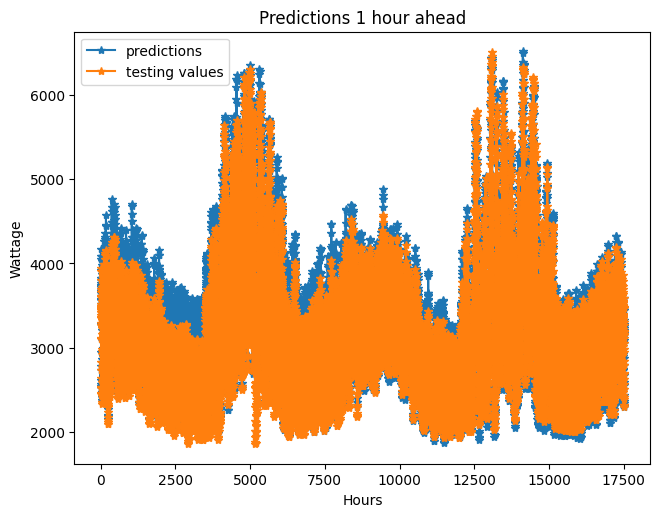

In [ ]:
Hours = [i for i in range(len(data[4]))]

fig = plt.figure();
axes = fig.add_axes([0.1, 0.1, 0.9, 0.9])
axes.plot(Hours, model.predict(data[4]), label = "predictions", marker = "*")
axes.plot(Hours, data[5], label = "testing values", marker= "*")

axes.set_xlabel("Hours")
axes.set_ylabel("Wattage")
plt.title("Predictions 1 hour ahead")
axes.legend()

# Calculate the MAE for Work Day and Weekend Days! 

In [ ]:
display(LSTMData)

,Annual Usage (kWh),Year,Month,Day,Hour,WeekDay or Weekend,HVN_lon,HVN_lat,HVN_tmpf,HVN_drct,...,DXR_drct,DXR_sknt,DXR_vsby,MMK_lon,MMK_lat,MMK_tmpf,MMK_drct,MMK_sknt,MMK_vsby,HotTemperatures
0,13244.454545,2011,1,1,0,0,-72.8868,41.2638,33.980000,190.000000,...,0.000000,0.000000,5.000000,-72.83,41.51,28.94,0.0,0.0,4.0,0
1,13244.454545,2011,1,1,1,0,-72.8868,41.2638,37.940000,63.333333,...,0.000000,0.000000,5.000000,-72.83,41.51,28.94,0.0,0.0,4.0,0
2,13244.454545,2011,1,1,2,0,-72.8868,41.2638,37.040000,200.000000,...,0.000000,0.000000,4.000000,-72.83,41.51,33.08,150.0,5.0,5.0,0
3,13244.454545,2011,1,1,3,0,-72.8868,41.2638,33.980000,130.000000,...,0.000000,0.000000,4.000000,-72.83,41.51,33.08,150.0,4.0,6.0,0
4,13244.454545,2011,1,1,4,0,-72.8868,41.2638,30.920000,130.000000,...,0.000000,0.000000,4.000000,-72.83,41.51,28.94,100.0,3.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96422,14064.500000,2021,12,31,19,0,-72.8868,41.2638,46.133333,86.666667,...,46.666667,1.333333,6.666667,-72.83,41.51,43.00,0.0,0.0,4.0,0
96423,14064.500000,2021,12,31,20,0,-72.8868,41.2638,46.133333,86.666667,...,46.666667,1.333333,6.666667,-72.83,41.51,43.00,0.0,0.0,4.0,0
96424,14064.500000,2021,12,31,21,0,-72.8868,41.2638,46.133333,86.666667,...,46.666667,1.333333,6.666667,-72.83,41.51,43.00,0.0,0.0,4.0,0
96425,14064.500000,2021,12,31,22,0,-72.8868,41.2638,46.133333,86.666667,...,46.666667,1.333333,6.666667,-72.83,41.51,43.00,0.0,0.0,4.0,0


# Weekday Weekend Results

In [ ]:
MAE_results = [0 for i in range(0,24,1)]
MAE_results2 = [0 for i in range(0,24,1)]
import datetime
def weekDayMAE(LSTMData, MAE_results, predictionsAdjusted, testingAdjusted):
    for i in range(0, 24, 1):
        HourlyPredictedVals = []
        HourlyActualVals = []  
        for index in range(0,len(predictionsAdjusted)): 
             datetimeObj = datetime.datetime(LSTMData.iloc[index + 18 + 61363, 1], LSTMData.iloc[index + 18 + 61363, 2], LSTMData.iloc[index + 18 + 61363, 3])
             if LSTMData.iloc[index + 18, 4] == i and datetimeObj.isoweekday() <=5: # if it is a weekday
                 HourlyPredictedVals.append(predictionsAdjusted[index])
                 HourlyActualVals.append(testingAdjusted[index])
        error = mean_absolute_error(HourlyPredictedVals, HourlyActualVals)
        MAE_results[i] = error; 

In [ ]:
def weekEndMAE(LSTMData, MAE_results, predictionsAdjusted, testingAdjusted):
    for i in range(0, 24, 1):
        HourlyPredictedVals = []
        HourlyActualVals = []  
        for index in range(0,len(predictionsAdjusted)): 
             datetimeObj = datetime.datetime(LSTMData.iloc[index + 18 + 61363, 1], LSTMData.iloc[index + 18 + 61363, 2], LSTMData.iloc[index + 18 + 61363, 3])
             if LSTMData.iloc[index + 18, 4] == i and datetimeObj.isoweekday() >5: # if it is a weekday
                 HourlyPredictedVals.append(predictionsAdjusted[index])
                 HourlyActualVals.append(testingAdjusted[index])
        error = mean_absolute_error(HourlyPredictedVals, HourlyActualVals)
        MAE_results[i] = error; 

In [ ]:
weekDayMAE(LSTMData, MAE_results, predictions, data[5])
weekEndMAE(LSTMData, MAE_results2, predictions, data[5])

Text(0.5, 1.0, 'LSTM6_Weekday')

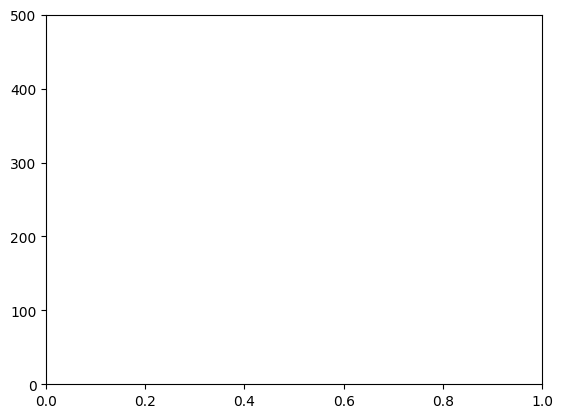

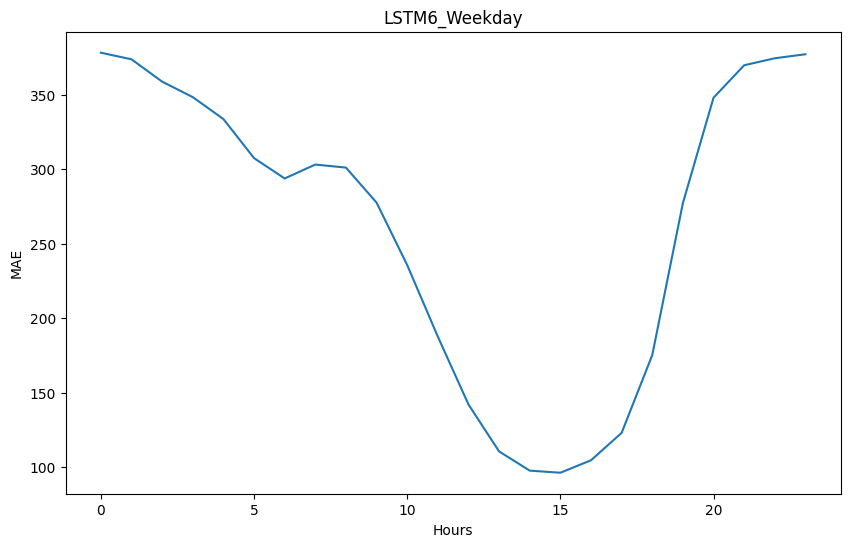

In [ ]:
Hours = [i for i in range(24)]
plt.ylim(0, 500)
plt.figure(figsize=(10,6))
plt.plot(Hours, MAE_results)
plt.xlabel("Hours")
plt.ylabel("MAE")
plt.title("LSTM6_Weekday")

Text(0.5, 1.0, 'LSTM6_Weekend')

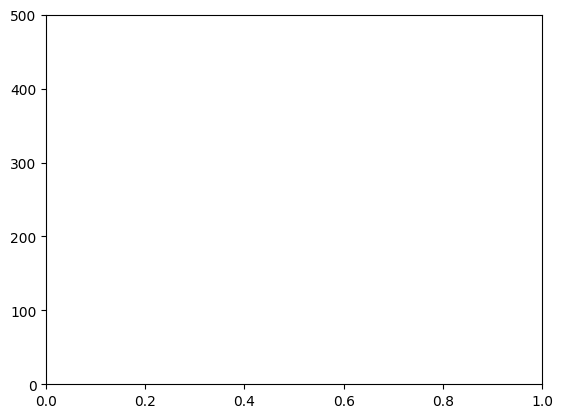

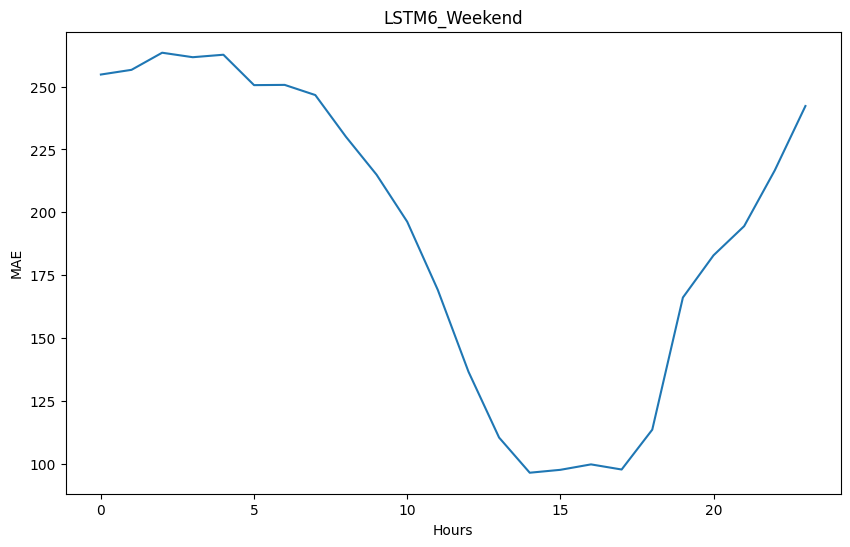

In [ ]:
plt.ylim(0, 500)
plt.figure(figsize=(10,6))
plt.plot(Hours, MAE_results2)
plt.xlabel("Hours")
plt.ylabel("MAE")
plt.title("LSTM6_Weekend")